In [25]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import rdata
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from fonctions_utiles import *


In [26]:
data_path = "data.Rdata" ; otu_path = "otu.Rdata"
converted_data = rdata.read_rds(data_path) ; converted_otu = rdata.read_rds(otu_path)
data_df = pd.DataFrame(converted_data['meta.full']) ; otu_df = pd.DataFrame(converted_otu['otu.full'])
print(f"Data_df ---> {data_df.shape}")
print(f"Otu_df ---> {otu_df.shape}")

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\rdata\parser\_parser.py:1239: UserWarning: Wrong extension .rds for file in RDATA format
  warnings.warn(  # noqa: B028


Data_df ---> (284, 61)
Otu_df ---> (284, 2565)


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\rdata\parser\_parser.py:1239: UserWarning: Wrong extension .rds for file in RDATA format
  warnings.warn(  # noqa: B028


### Méthodes et plan 

- Modèles simples : 
    - Regression Logistique
    - KNN 
    - Arbre de décision

- Modèles composés : 
    - Random Forest
    - XGBoost
    - Réseaux de neurone


## Preprocessing


## Pre-processing effectué

- data_df
  - Index = sample_name (nettoye, unique).
  - Colonnes gardees: age, diagnosis.
  - diagnosis en minuscules.
  - Lignes avec NaN supprimees.

- otu_df
  - Echantillons faibles retires: profondeur >= 12000.
  - OTUs gardes: prevalence >= 5% et somme totale >= 50.
  - CLR (par ligne): +1 (pour éviter les 0)-> fermeture (proportions) -> log -> centrage (moyenne des logs soustraite).
  - Filtre post-CLR: retrait des 5% d'OTUs a plus faible variance.

- Fusion
  - Jointure interne sur l'index des echantillons: `merged = data_df.join(otu_df_clr, how='inner')`. On obtient donc `merged_df`.

In [27]:
def purge_df_data(df : pd.DataFrame) -> pd.DataFrame : 
    """
    Fonction de faire le préprocessing du dataframe data_df.
    
    Paramètres : 
        df (pd.DataFrame) : DataFrame avant la purge.
    
    Retour : 
        result_df (pd.DataFrame) : DataFrame après la purge.
    """
    
    # Mettre le sample name comme index
    df_clean = df.set_index('sample_name')
    
    # Garder age et diagnosis
    df_clean = df_clean.loc[:,["age","diagnosis"]]
    
    # Mise en miniscule des str
    df_clean["diagnosis"] = df_clean["diagnosis"].apply(lambda s : s.lower())
    
    # Suppression des lignes ayant au moins un nan     
    df_clean = df_clean[~df_clean.isna().any(axis=1)] 
    
    return df_clean


def purge_df_otu(df : pd.DataFrame) -> pd.DataFrame : 
    """
    Fonction de faire le préprocessing du dataframe otu_df.
    
    Paramètres : 
        df (pd.DataFrame) : DataFrame avant la purge.
    
    Retour : 
        result_df (pd.DataFrame) : DataFrame après la purge.
    """
    
    ## Enlever les échantillons à faible profondeur
    threshold = 5e3
    cleaned_otu_df = df.loc[df.sum(axis=1) >= threshold]
    
    ## Récupérer les OTU qui sont présents dans au moins 5% des échantillons
    
    first_cond = (cleaned_otu_df.gt(0).sum(axis=0) / cleaned_otu_df.shape[0]) >= 0.05
    
    ## Enlever les OTU ultra faibles aussi (au minimum au total sur tous les échantillons)
    
    second_cond = cleaned_otu_df.sum(axis=0) >= 50
    
    cleaned_otu_df = cleaned_otu_df.loc[:,first_cond & second_cond]
       
    ## Transformation clr pour normaliser les données
    copy_otu_df = cleaned_otu_df.copy()
    copy_otu_df += 1 # Ajout du 0 pour éviter d'avoir des erreurs sur le log
    copy_otu_df = copy_otu_df.div(copy_otu_df.sum(axis=1),axis=0) # Diviser pour avoir une proportion
    log_otu_df = np.log(copy_otu_df) # Chercher le log
    clr_otu_df =  log_otu_df.sub(log_otu_df.mean(axis=1),axis=0) # Pour retrancher contre la moyenne
    
    cleaned_otu_df = clr_otu_df
    
    ## Puis garder les plus variables parmi les otu (pour retirer les OTU qui sont quasi constants car peu informatifs)
    
    var = cleaned_otu_df.var(axis=0)
    thr = np.quantile(var, 0.05)
    
    cleaned_otu_df = cleaned_otu_df.loc[:, var > thr]
    
    return cleaned_otu_df

def mergin(df1 : pd.DataFrame,df2 : pd.DataFrame) -> pd.DataFrame : 
    """
    Pour merger les deux dataframes. 
    (Faire attention à l'ordre)
    Paramètres : 
        df1 (pd.DataFrame) = data.Rdata
        df2 (pd.DataFrame) = otu.Rdata
        
    Retour : 
        merged_df (pd.DataFrame) = le dataframe 
    """
    cleaned_df1 = purge_df_data(df1)
    cleaned_df2 = purge_df_otu(df2)
    merged_df = cleaned_df1.join(cleaned_df2, how='inner')
    
    return merged_df

In [28]:
merged_df = mergin(data_df,otu_df)

### Après fusion 

- Sur la colonne `diagnosis`, on classe ceux qui sont malades comme `yes`, et ceux non malades comme `no`.

In [29]:
merged_df["diagnosis"] = merged_df["diagnosis"].apply(lambda s : "healthy" if s =="no" else "disease")

In [30]:
# merged_df.to_csv("final_df_sick_no_sick.csv",index=False)

In [31]:

input_dim = merged_df.shape[1]-1 # Entrée du réseau de neurones
num_classes = len(merged_df["diagnosis"].value_counts())

# Réseaux de neurones prêt
model = build_model(input_dim=input_dim,num_classes=num_classes,lr=3e-4)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │       268,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,041 (1.19 MB)

 Trainable params: 310,145 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1
 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1
 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1
 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0
 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0]
La taille de X_train est : (158, 1046)
La taille de X_test est : (86, 1046)
La taille de X_val est : (40, 1046)
Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.5443 - auc: 0.4706 - loss: 0.8727 - val_accuracy: 0.5000 - val_auc: 0.3942 - val_loss: 0.7440 - learning_rate: 3.0000e-04
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5316 - auc: 0.5204 - loss: 0.8109 - val_accuracy: 0.5500 - v

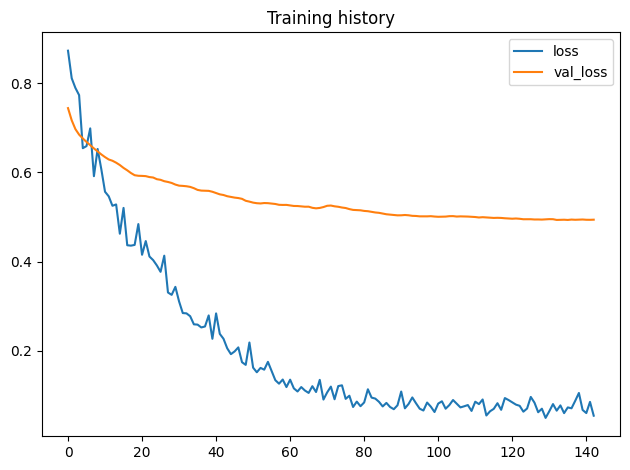

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
              precision    recall  f1-score   support

     disease       0.84      0.75      0.79        55
     healthy       0.62      0.74      0.68        31

    accuracy                           0.74        86
   macro avg       0.73      0.74      0.73        86
weighted avg       0.76      0.74      0.75        86



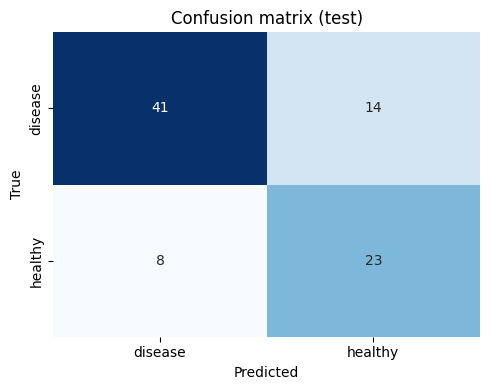

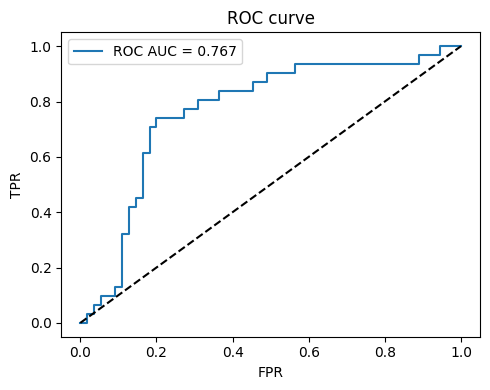

Best threshold (Youden J): 0.7008  | J=0.5419  | TPR=0.7419  | FPR=0.2000
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        55
           1       0.68      0.74      0.71        31

    accuracy                           0.78        86
   macro avg       0.76      0.77      0.77        86
weighted avg       0.78      0.78      0.78        86

Confusion matrix:
 [[44 11]
 [ 8 23]]


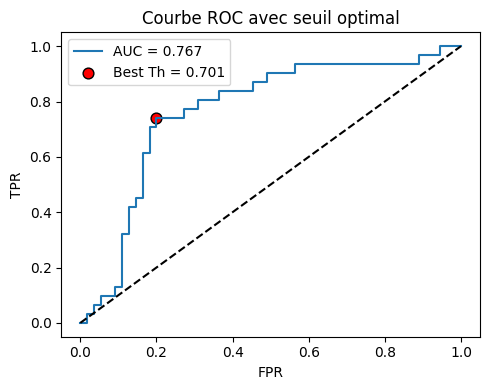

In [32]:
# Entrainement du réseau de neurones
train_model(model,merged_df,label_col="diagnosis",batch_size=32,do_acp=False)

### Analyse

- Rappel des formules : 
    - `Précision` : VP / (VP + FP)  , Mesure la proportion de vrais positifs parmi toutes les prédictions positives.
    - `Rappel` : VP  / (VP+FN) , Mesure la proportion de vrais positifs parmi ceux qui sont réelement positifs.
    - `F1-score` : Moyenne harmonique entre le rappel et la précision.

- Rappel sur les labels : 
    - 0 = `disease`
    - 1 = `healthy`

- Analyse matrice de confusion : 

    - Pour la classe `disease` : 
        - `Précision` =  0.87, parmi tous les malades prédits, il y'en a 87% qui sont bons.
        - `Rappel` = 0.75, parmi ceux qui réelement malades, on a bien prédit 75%. 
        - `F1-score` = 0.80

    - Pour la classe `healthy` : 
        - `Précision` =  0.64, parmi tous les malades prédits, il y'en a 64% qui sont bons.
        - `Rappel` = 0.81, 
        - `F1-score` = 0.71   

On constate que, le modèle a de bonnes prédictions sur la classe `disease` et se trompe que 1/4 sur les vrais malades.
Contrairement à la classe `healthy`, ou les prédictions dessus sont moins bonnes (`64%`), cependant il se trompe moins dans ses prédictions.

Donc au final, le modèle est plus sur lorsqu'il prédit `disease` que `healthy`.



In [19]:
# merged_df.to_csv("final_df.csv")

In [20]:
# depth = otu_df.sum(axis=1)
# plt.figure(figsize=(5,4))
# plt.hist(depth, bins=50, color='steelblue')
# plt.xscale('log'); plt.title('Histogramme en log(x)')
# plt.xlabel('Profondeur'); plt.ylabel('Comptes')
# plt.axvline(1.2e4, color='crimson', ls='--', lw=2,label=f'seuil = {1.2e4}')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [21]:
# # Top-N variance filter on CLR OTUs and rebuild merged dataset
# N = 500  # try 300/500/700
# var = otu_df_clean.var(axis=0)
# keep = var.sort_values(ascending=False).head(N).index.tolist()
# merged_topvar = merged_df[['age','diagnosis']].join(otu_df_clean[keep], how='inner')
# print('merged_topvar shape:', merged_topvar.shape)


In [22]:
# # Build and train improved model on top-variance features
# input_dim_tv = merged_topvar.shape[1] - 1
# num_classes_tv = merged_topvar['diagnosis'].nunique()
# model_tv = build_model(input_dim_tv, num_classes_tv, lr=3e-4, l2=1e-3)
# res_tv = train_model(model_tv, merged_topvar, label_col='diagnosis', batch_size=16, epochs=200, random_state=42)
# res_tv['history'][['loss','val_loss']].plot(title='Training history (top-variance)'); plt.show()


In [23]:
# # Evaluation on held-out test set
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# le = res_tv['label_encoder']
# X_test = res_tv['X_test']; y_test_int = res_tv['y_test_int']
# K = len(le.classes_)
# if K == 2:
#     probs = res_tv['model'].predict(X_test).ravel()
#     preds = (probs >= 0.5).astype(int)
#     auc = roc_auc_score(y_test_int, probs)
# else:
#     probs = res_tv['model'].predict(X_test)
#     preds = probs.argmax(axis=1)
#     auc = roc_auc_score(y_test_int, probs, multi_class='ovr')
# print('Classes:', list(le.classes_))
# print(classification_report(y_test_int, preds, target_names=le.classes_))
# print('Confusion matrix:', confusion_matrix(y_test_int, preds))
# print('AUC:', auc)


In [24]:
# # PCA pipeline: scale -> PCA -> NN (fit PCA on train only)
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# import numpy as np, pandas as pd

# # 1) Features/labels from merged_df
# X_all = merged_df.drop(columns=['diagnosis']).values
# y_raw = merged_df['diagnosis'].astype(str).values

# # 2) Encode labels to ints (needed for class weights)
# le_pca = LabelEncoder()
# y_int_all = le_pca.fit_transform(y_raw)
# K_pca = len(le_pca.classes_)
# y_all = y_int_all if K_pca == 2 else keras.utils.to_categorical(y_int_all, num_classes=K_pca)

# # 3) Stratified splits
# a = train_test_split(X_all, y_all, y_int_all, test_size=0.2, stratify=y_int_all, random_state=42)
# X_tr, X_test, y_tr, y_test, y_tr_int, y_test_int = a
# b = train_test_split(X_tr, y_tr, y_tr_int, test_size=0.2, stratify=y_tr_int, random_state=42)
# X_tr, X_val, y_tr, y_val, y_tr_int, y_val_int = b

# # 4) Scale on train only
# scaler_pca = StandardScaler()
# X_tr_s = scaler_pca.fit_transform(X_tr)
# X_val_s = scaler_pca.transform(X_val)
# X_test_s = scaler_pca.transform(X_test)

# # 5) PCA on scaled train only
# pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
# Z_tr = pca.fit_transform(X_tr_s)
# Z_val = pca.transform(X_val_s)
# Z_test = pca.transform(X_test_s)
# print('PCA components:', pca.n_components_)

# # 6) Class weights from 1D labels
# classes_arr = np.arange(K_pca) if K_pca > 2 else np.unique(y_tr_int)
# cw_vals = compute_class_weight('balanced', classes=classes_arr, y=y_tr_int)
# class_weights_pca = {int(c): float(w) for c, w in zip(classes_arr, cw_vals)}

# # 7) Build and train model on PCs
# model_pca = build_model(input_dim=Z_tr.shape[1], num_classes=K_pca, lr=3e-4, l2=1e-3)
# callbacks = [
#     keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, min_delta=1e-3, restore_best_weights=True),
#     keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5),
# ]
# history_pca = model_pca.fit(
#     Z_tr, y_tr,
#     validation_data=(Z_val, y_val),
#     epochs=200, batch_size=16,
#     class_weight=class_weights_pca, shuffle=True, verbose=1,
#     callbacks=callbacks
# )

# pd.DataFrame(history_pca.history)[['loss','val_loss']].plot(title='Training history (PCA)'); plt.show()

# # 8) Evaluate on held-out test set
# if K_pca == 2:
#     probs = model_pca.predict(Z_test).ravel()
#     preds = (probs >= 0.5).astype(int)
#     auc = roc_auc_score(y_test_int, probs)
# else:
#     probs = model_pca.predict(Z_test)
#     preds = probs.argmax(axis=1)
#     auc = roc_auc_score(y_test_int, probs, multi_class='ovr')
# print('Classes:', list(le_pca.classes_))
# print(classification_report(y_test_int, preds, target_names=le_pca.classes_))
# print('Confusion matrix:', confusion_matrix(y_test_int, preds))
# print('AUC:', auc)

